# RNN Based molucule generation

Laurent Cetinsoy

In this hands-on we want to generate molecule formulas for denovo-drug discovery.

For that we need to use Generative models. Generative models are models which goes beyond classification or simple regression : they are able to generate data that look like previously seens dataset.

There exists a lot of models :

- Bayesian models like graphical models
- Recurrent models (for sequence generation like texte)
- Variational auto encoders
- Generative adversarial models
- Flow and diffusion models


In the hands-on we will start by  trainning a character based RNN to generate smile molecules


We want to feed smile representations of molecules to an RNN.
The basic idea is we will train it to predict the next smile token of a molecule given the previous one.

For instance for the following molecule "CC(=O)NC1=CC=C(O)C=C1" will may give to the model

X = "CC(=O)N"
y = C

and ask the RNN to learn to predict y given X

Like a standard language model !


## RNN Language model


A language model is a model which predict the next token of a sequence given the previous ones :

$ P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p})  $


This model can be learned with a Recurrent neural network

$ y = P(X_t | X_{t-1}, X_{t-2}, ..., X_{t-p}) = RNN_{\theta} (X_{t-1}, X_{t-2}, ..., X_{t-p})  $


In order to train such model you need a corpus of data.



There are two main ways to do that : Word level model or character level model

For character level models, an interesting resource is : http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Explain briefly what is the difference between word based language model and character based language model

## Loading the data

Dowload the following dataset : https://github.com/joeymach/Leveraging-VAE-to-generate-molecules

Import pandas and load the first 1000 lines

In [75]:
import pandas as pd

path = './250k_smiles.csv'
df = pd.read_csv(path, nrows=1000)

Display the first rows of the dataframe

In [76]:
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Processing the data

We need to do the following things :

- convert smile tokens to numbers
- build  smile token sequences and corresponding labels pairs

Compute the biggest smile molecule size

In [77]:
# compute the biggest molecule size
mole_sizes = df['smiles'].apply(lambda x: len(x))
print('max size: ', mole_sizes.max())

max size:  106



Code a function **unic_characters(string)** which return the unic characters in a string


In [78]:
def unic_characters(string):
    return set(string)

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [79]:
# concat all smiles
all_smiles = ''.join(df['smiles'].values)

all_chars = unic_characters(all_smiles)
print('all chars: ', all_chars)
print('all chars len: ', len(all_chars))

all chars:  {'3', 's', ']', '+', '4', 'F', '\\', 'H', '-', 'N', '[', 'r', 'S', 'l', 'c', '7', '6', 'C', '\n', '5', ')', 'O', 'n', '=', '#', '@', '(', 'I', '2', '1', 'B', 'o', '/'}
all chars len:  33


Code a function **map_char_to_int(unic_chars)** which returns a dictionnary where each char is assigned an int value.
Add a character to specify the end of the molecule (like "\n")


In [80]:
def map_char_to_int(unic_chars):
    dic = {char: i for i, char in enumerate(unic_chars)}
    # add _ to the dictionary
    dic['_'] = len(dic)
    return dic

# test it with all_chars
char_to_int = map_char_to_int(all_chars)
print('char_to_int: ', char_to_int)

char_to_int:  {'3': 0, 's': 1, ']': 2, '+': 3, '4': 4, 'F': 5, '\\': 6, 'H': 7, '-': 8, 'N': 9, '[': 10, 'r': 11, 'S': 12, 'l': 13, 'c': 14, '7': 15, '6': 16, 'C': 17, '\n': 18, '5': 19, ')': 20, 'O': 21, 'n': 22, '=': 23, '#': 24, '@': 25, '(': 26, 'I': 27, '2': 28, '1': 29, 'B': 30, 'o': 31, '/': 32, '_': 33}


Code a function map_int_to_char(unic_chars) which returns the reverse mapping.

If you want you can merge both functions in a class

In [81]:
def map_int_to_char(unic_chars):
    dic = {i: char for i, char in enumerate(unic_chars)}
    # add \n to the dictionary
    dic[len(dic)] = '_'
    return dic

# test it with all_chars
int_to_char = map_int_to_char(all_chars)
print('int_to_char: ', int_to_char)

int_to_char:  {0: '3', 1: 's', 2: ']', 3: '+', 4: '4', 5: 'F', 6: '\\', 7: 'H', 8: '-', 9: 'N', 10: '[', 11: 'r', 12: 'S', 13: 'l', 14: 'c', 15: '7', 16: '6', 17: 'C', 18: '\n', 19: '5', 20: ')', 21: 'O', 22: 'n', 23: '=', 24: '#', 25: '@', 26: '(', 27: 'I', 28: '2', 29: '1', 30: 'B', 31: 'o', 32: '/', 33: '_'}


For each smile molecule add the ending token to it

In [82]:
# add _ at the end of each smiles
df['smiles'] = df['smiles'].apply(lambda x: x + '_')
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n_,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n_,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


## Building the dataset

Now we will create the dataset so that it has the good share for our Keras LSTM model

Remember Keras recurrent models expect a 3D array with shapes (n_examples, seq_len, n_features)



What will be n_features in our case ?

n_features will be the number of different characters in our dataset

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

Test your function on the following string "" with seq_length = 4 and i = [1, 2, 3]

In [83]:
def build_X_and_y(string, i_char, seq_length):
    if str == None:
        return None, None

    if i_char + seq_length >= len(string):
        return None, None

    X = string[i_char : i_char + seq_length]
    y = string[i_char + seq_length]
    return X, y

# Example usage:
s = "abcdefg"
positions = [1, 2, 3]
sequence_length = 4
for i in positions:
    X, y = build_X_and_y(s, i, sequence_length)
    print(f"For i = {i}, X: {X}, y: {y}")

s = ""
positions = [1, 2, 3]
sequence_length = 4
for i in positions:
    X, y = build_X_and_y(s, i, sequence_length)
    print(f"For i = {i}, X: {X}, y: {y}")

For i = 1, X: bcde, y: f
For i = 2, X: cdef, y: g
For i = 3, X: None, y: None
For i = 1, X: None, y: None
For i = 2, X: None, y: None
For i = 3, X: None, y: None


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [108]:
X_train = []
y_train = []

for i in range(len(all_smiles)):
    seq_length = 10
    X, y = build_X_and_y(all_smiles, i, seq_length)
    if X != None and y != None:
        L = [char_to_int[char] for char in X]
        X_train.append(L)
        y_train.append(char_to_int[y])

print('X_train: ', X_train[:10])
print('y_train: ', y_train[:10])
print('X_train len: ', len(X_train))
print('y_train len: ', len(y_train))

X_train:  [[17, 17, 26, 17, 20, 26, 17, 20, 14, 29], [17, 26, 17, 20, 26, 17, 20, 14, 29, 14], [26, 17, 20, 26, 17, 20, 14, 29, 14, 14], [17, 20, 26, 17, 20, 14, 29, 14, 14, 14], [20, 26, 17, 20, 14, 29, 14, 14, 14, 28], [26, 17, 20, 14, 29, 14, 14, 14, 28, 31], [17, 20, 14, 29, 14, 14, 14, 28, 31, 14], [20, 14, 29, 14, 14, 14, 28, 31, 14, 14], [14, 29, 14, 14, 14, 28, 31, 14, 14, 26], [29, 14, 14, 14, 28, 31, 14, 14, 26, 17]]
y_train:  [14, 14, 14, 28, 31, 14, 14, 26, 17, 17]
X_train len:  45232
y_train len:  45232


Create numpy arrays from the lists

In [109]:
import numpy as np
X_train = np.array(X_train, dtype=np.int32)
y_train = np.array(y_train, dtype=np.int32)

Reshape the X numpy array (n_examples, seq_lenght, 1)

In [110]:
X_train.shape, y_train.shape

((45232, 10), (45232,))

In [111]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_train.shape

(45232, 10, 1)

Normalize X by dividing each values by the total number of unic characters

In [112]:
# Normalize X_train
n_unique_chars = len(all_chars)
X_train_normalized = X_train / n_unique_chars

print(X_train_normalized[:1])
print(X_train_normalized.max())
print(X_train_normalized.min())

[[[0.51515152]
  [0.51515152]
  [0.78787879]
  [0.51515152]
  [0.60606061]
  [0.78787879]
  [0.51515152]
  [0.60606061]
  [0.42424242]
  [0.87878788]]]
0.9696969696969697
0.0


Import Keras and build (at least) a two layered LSTM network with 128 neurone in each.

You can also add Dropoutlayers

Do you think you should use the return_sequences = True ? If yes, when ?


Add a Dense layer on top with with the appropriate activation function and number of neurones


In [113]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()

# First LSTM layer
model.add(LSTM(128, input_shape=(X_train_normalized.shape[1], X_train_normalized.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer

# Second LSTM layer
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))  # Dropout layer

model.add(Dense(len(all_chars), activation='softmax'))


Compile the model with the appropriate loss function and the adam optimizer

In [114]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_10 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 33)                4257      
                                                                 
Total params: 202401 (790.63 KB)
Trainable params: 202401 (790.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [115]:
from keras.utils import to_categorical


# Slice out 10 examples
X_train_subset = X_train_normalized[:10]
y_train_subset = y_train[:10]
y_train_subset_encoded = to_categorical(y_train_subset, num_classes=len(all_chars))

# Train the model on the subset
history = model.fit(X_train_subset, y_train_subset_encoded, epochs=20, verbose=1)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 3.4955 - accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 3.4450 - accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 6ms/step - loss: 3.4065 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 6ms/step - loss: 3.3451 - accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 3.2716 - accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 3.1894 - accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 6ms/step - loss: 3.1033 - accuracy: 0.5000
Epoch 8/20
1/1 [==============================] - 0s 5ms/step - loss: 2.9480 - accuracy: 0.5000
Epoch 9/20
1/1 [==============================] - 0s 6ms/step - loss: 2.7802 - accuracy: 0.5000
Epoch 10/20
1/1 [==============================] - 0s 5ms/step - loss: 2.5595 - accuracy: 0.5000
Epoch 11/20
1/1 [===================

If it does not overfit try to fix data prep and model architecture so it does

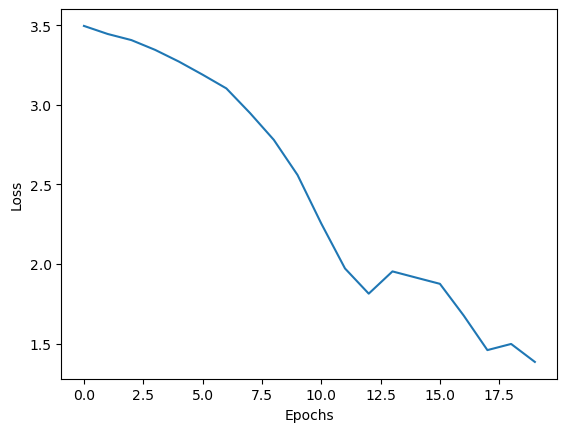

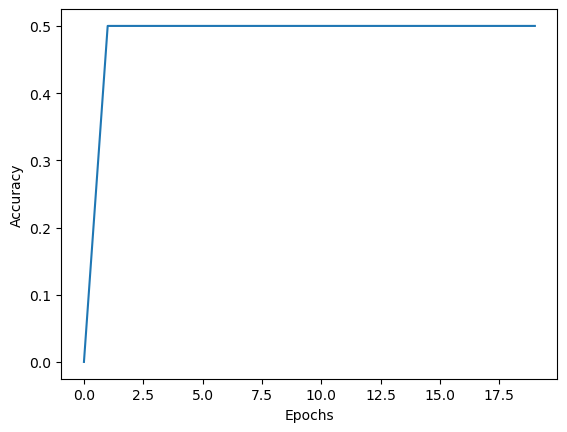

In [116]:
# Plot the loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [117]:
# test the model on the other part of the dataset
X_test = X_train_normalized[10:]
y_test = y_train[10:]
y_test_encoded = to_categorical(y_test, num_classes=len(all_chars))

model.evaluate(X_test, y_test_encoded)

1414/1414 [==============================] - 3s 2ms/step - loss: 3.8238 - accuracy: 0.1977


[3.8237743377685547, 0.19766928255558014]

the model definitively overfits !

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [122]:
def make_prediction(seed_start, model, char_to_int, int_to_char, seq_length=10, max_len=100):
    molecule = seed_start
    
    # Truncate or pad the seed_start to match the expected sequence length
    if len(seed_start) > seq_length:
        input_seq = seed_start[-seq_length:]
    else:
        input_seq = seed_start.ljust(seq_length)  # pad with spaces to the right

    for _ in range(max_len):
        # Convert input_seq to the appropriate format for prediction
        integer_encoded = [char_to_int.get(char, 0) for char in input_seq]  # 0 for padding character or unknown characters
        integer_encoded = np.array(integer_encoded).reshape(1, len(integer_encoded), 1)
        integer_encoded = integer_encoded / float(len(all_chars))  # Normalize

        # Predict the next character
        prediction = model.predict(integer_encoded, verbose=0)
        int_prediction = np.argmax(prediction)

        # Convert integer prediction back to character
        next_char = int_to_char[int_prediction]

        # Stop if the termination character is predicted
        if next_char == '_':
            break

        # Append the predicted character to the molecule and update input_seq
        molecule += next_char
        input_seq = input_seq[1:] + next_char

    return molecule

generate a molecule of your overfitted model

In [123]:
seed_start = "C1=CC=CC=C1"  # Just an example seed. You can replace it with any other seed sequence.
generated_molecule = make_prediction(seed_start, model, char_to_int, int_to_char)
print(generated_molecule)

C1=CC=CC=C1cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


Make a model checkpoint so that the model is saved after each epoch
if you train on a plateform and it stops you do not lose your training

In [124]:
from keras.callbacks import ModelCheckpoint

filepath = "model_checkpoints/model_epoch_{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min')
callbacks_list = [checkpoint]

Now go to your favorite plateform (colab or something else) and train the dataset on the whole data for 10 epochs and batch size 256

it should take a long time so either follow the class or go take a nap

In [134]:
y_train_encoded = to_categorical(y_train, num_classes=len(all_chars))

model.fit(X_train_normalized, y_train_encoded, epochs=20, batch_size=256, callbacks=callbacks_list)

Epoch 1/20
175/177 [============================>.] - ETA: 0s - loss: 1.7836 - accuracy: 0.4496
Epoch 1: saving model to model_checkpoints/model_epoch_01.hdf5
177/177 [==============================] - 3s 18ms/step - loss: 1.7839 - accuracy: 0.4494
Epoch 2/20
 10/177 [>.............................] - ETA: 2s - loss: 1.7173 - accuracy: 0.4605

/home/pierre/miniconda3/envs/video_proc_env/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


175/177 [============================>.] - ETA: 0s - loss: 1.7300 - accuracy: 0.4652
Epoch 2: saving model to model_checkpoints/model_epoch_02.hdf5
177/177 [==============================] - 3s 17ms/step - loss: 1.7290 - accuracy: 0.4654
Epoch 3/20
175/177 [============================>.] - ETA: 0s - loss: 1.6747 - accuracy: 0.4846
Epoch 3: saving model to model_checkpoints/model_epoch_03.hdf5
177/177 [==============================] - 3s 17ms/step - loss: 1.6750 - accuracy: 0.4844
Epoch 4/20
175/177 [============================>.] - ETA: 0s - loss: 1.6359 - accuracy: 0.4935
Epoch 4: saving model to model_checkpoints/model_epoch_04.hdf5
177/177 [==============================] - 3s 17ms/step - loss: 1.6365 - accuracy: 0.4932
Epoch 5/20
175/177 [============================>.] - ETA: 0s - loss: 1.6024 - accuracy: 0.5041
Epoch 5: saving model to model_checkpoints/model_epoch_05.hdf5
177/177 [==============================] - 3s 17ms/step - loss: 1.6021 - accuracy: 0.5043
Epoch 6/20
175/

Generate between 100 and 1000 molecules.

create a list where molecules have between 10 and 50 atoms

In [138]:
seed_start = "C1=CC=CC=C1"  # Just an example seed. You can replace it with any other seed sequence.
generated_molecule = make_prediction(seed_start, model, char_to_int, int_to_char)
print(generated_molecule)

C1=CC=CC=C1=O)NCCCCC1=cc1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCC


In [142]:
import random
generated_molecules = []

while len(generated_molecules) < 20:
    seed_start = random.choice(all_smiles)[:10]  # Picking a random starting sequence for variety
    generated_molecule = make_prediction(seed_start, model, char_to_int, int_to_char, seq_length=10)

    generated_molecules.append(generated_molecule)

    print(len(generated_molecules))
        

# Display the generated molecules
print(generated_molecules[:100])  # Displaying first 100 for brevity

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
['(CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', ')CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', '1CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 'CCCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', '[CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', '1CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 'cCCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', '/CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 'OCCCCC2)c1\nCCCCC1)C1\nCCCC

With rdkit compute the Quantified Estimated Drug likelyness (QED) of each molecule in this subset

In [143]:
from rdkit import Chem
from rdkit.Chem import QED

# Convert SMILES strings to RDKit molecules
molecule_objects = [Chem.MolFromSmiles(smiles) for smiles in generated_molecules]

# Compute QED for each molecule
qed_values = [QED.qed(mol) if mol else 0 for mol in molecule_objects]

# Pairing each molecule with its QED for easy viewing
molecule_qed_pairs = list(zip(generated_molecules, qed_values))

# Display the first few pairs for brevity
print(molecule_qed_pairs[:10])

[('(CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), (')CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('1CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('CCCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('[CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('1CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('cCCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('/CCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1\nCCCC1)C1', 0), ('OCCCCC2)c1\nCCCCC1)C1\nCCCC1)C1\nCCCC

[15:15:27] SMILES Parse Error: syntax error while parsing: (CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
[15:15:27] SMILES Parse Error: Failed parsing SMILES '(CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1' for input: '(CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1'
[15:15:27] SMILES Parse Error: syntax error while parsing: )CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
[15:15:27] SMILES Parse Error: Failed parsing SMILES ')CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1' for input: ')CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1'
[15:15:27] SMILES Parse Error: syntax error while parsing: 1CCCCC2)c1
CCCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1
CCCC1)C1


My rnn is not trained enough ad seems to generate only a sequence of the same character loop. It seems it needs more layers and more training.

Bonus 1 : Using rdkit, compute the quantitative estimation of drug-likeness (QED) of your generated molecules.

Bonus 2 : try to adapt a transformer model training from hugging face to see if it is better